# Image Denoising using Autoencoders + Predictions using the Autoencoder

In [1]:
import numpy as np
import tensorflow as tf

### Data Loading

In [25]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print('Number of train samples: {}, Number of test samples: {}'.format(X_train.shape, X_test.shape))

Number of train samples: (60000, 28, 28), Number of test samples: (10000, 28, 28)


### Normalizing the data values between 0 & 1

In [26]:
X_train = X_train / 255.
X_test = X_test / 255.

In [27]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Inducing Noise in the data

In [28]:
factor = 0.5
X_train_noisy = X_train + factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

In [6]:
import matplotlib.pyplot as plt

### Visualizing Noise induced data

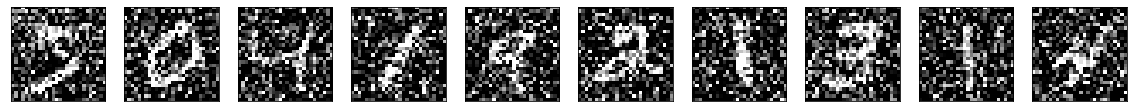

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Training a Convolution Autoencoder

In [8]:
inputs = tf.keras.layers.Input(shape=(28, 28, 1))

## Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='input')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='encoder')(x)

## Decoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = tf.keras.models.Model(inputs, decoder)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
input (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0     

In [9]:
model.fit(X_train_noisy, X_train, 
          epochs=20, batch_size=256, 
          validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 29s 491us/sample - loss: 0.1901 - accuracy: 0.8066 - val_loss: 0.1212 - val_accuracy: 0.8097
Epoch 2/20
60000/60000 [==============================] - 25s 415us/sample - loss: 0.1164 - accuracy: 0.8107 - val_loss: 0.1114 - val_accuracy: 0.8112
Epoch 3/20
60000/60000 [==============================] - 25s 418us/sample - loss: 0.1096 - accuracy: 0.8117 - val_loss: 0.1063 - val_accuracy: 0.8107
Epoch 4/20
60000/60000 [==============================] - 32s 540us/sample - loss: 0.1053 - accuracy: 0.8123 - val_loss: 0.1033 - val_accuracy: 0.8119
Epoch 5/20
60000/60000 [==============================] - 40s 671us/sample - loss: 0.1028 - accuracy: 0.8126 - val_loss: 0.1013 - val_accuracy: 0.8118
Epoch 6/20
60000/60000 [==============================] - 41s 680us/sample - loss: 0.1015 - accuracy: 0.8128 - val_loss: 0.1006 - val_accuracy: 0.8123
Epoch 7/20
60000/60000 [====================

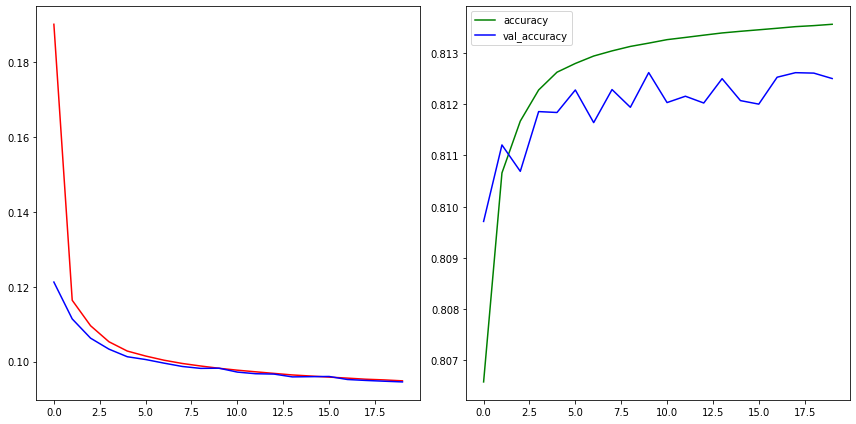

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='loss', c='r')
plt.plot(model.history.history['val_loss'], label='loss', c='b')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy', c='g')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', c='b')

plt.legend()
plt.tight_layout()

### Extracting the Encoder from the Autoencoder

In [11]:
encoder = tf.keras.models.Model(inputs, encoder)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
input (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 7, 7, 64)          0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


### Predictions on the Noisy (Test) images + visualization

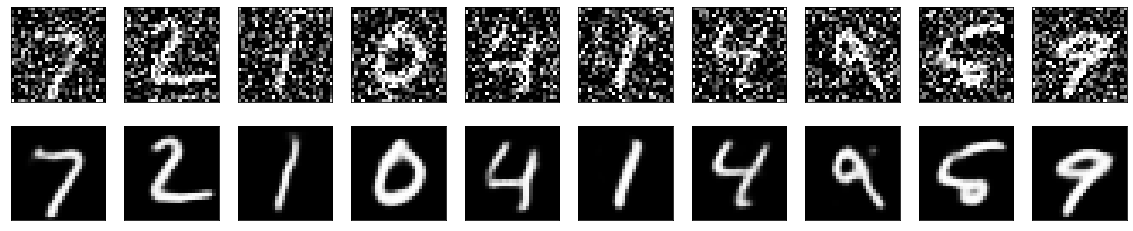

In [12]:
decoded_images = model.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Setting the layers of the pre-trained encoder to not re-train

In [13]:
## Setting encoder layers to not retrain
for layer in encoder.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F48A339408> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F48A3393C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F48A33D3C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F48A379508> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F48A36E548> False


### Classification model using the pre-trained Encoder + FC layers

In [34]:
## Classification model with the pre-trained Autoencoder head
model = tf.keras.models.Sequential()
model.add(encoder)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 64)          18816     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                100384    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 119,530
Trainable params: 100,714
Non-trainable params: 18,816
_________________________________________________________________


In [30]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print('Shape of y_train: {}, shape of y_test: {}'.format(y_train.shape, y_test.shape))

Shape of y_train: (60000, 10), shape of y_test: (10000, 10)


In [35]:
model.fit(X_train, y_train, 
          epochs=20, 
          batch_size=128, 
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 111us/sample - loss: 0.3626 - accuracy: 0.9245 - val_loss: 0.1917 - val_accuracy: 0.9664
Epoch 2/20
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1800 - accuracy: 0.9690 - val_loss: 0.1573 - val_accuracy: 0.9756
Epoch 3/20
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1576 - accuracy: 0.9732 - val_loss: 0.1538 - val_accuracy: 0.9729
Epoch 4/20
60000/60000 [==============================] - 6s 100us/sample - loss: 0.1452 - accuracy: 0.9758 - val_loss: 0.1366 - val_accuracy: 0.9779
Epoch 5/20
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1369 - accuracy: 0.9775 - val_loss: 0.1326 - val_accuracy: 0.9779
Epoch 6/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1306 - accuracy: 0.9786 - val_loss: 0.1344 - val_accuracy: 0.9751
Epoch 7/20
60000/60000 [=============================

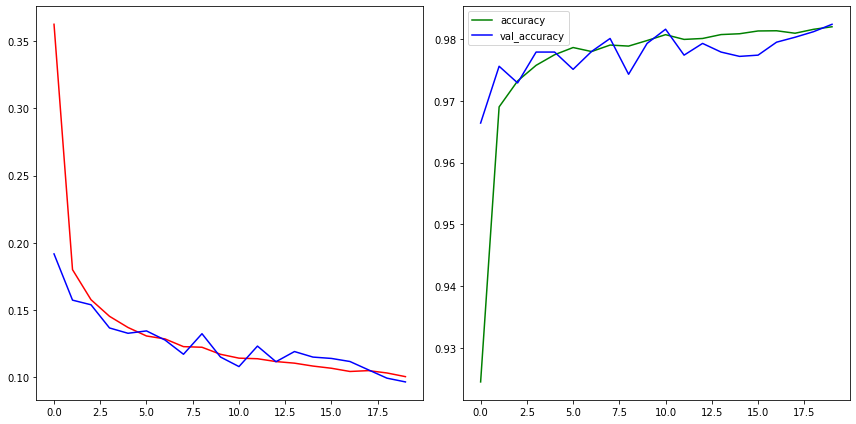

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='loss', c='r')
plt.plot(model.history.history['val_loss'], label='loss', c='b')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy', c='g')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', c='b')

plt.legend()
plt.tight_layout()

### Predictions on noisy images + visualization

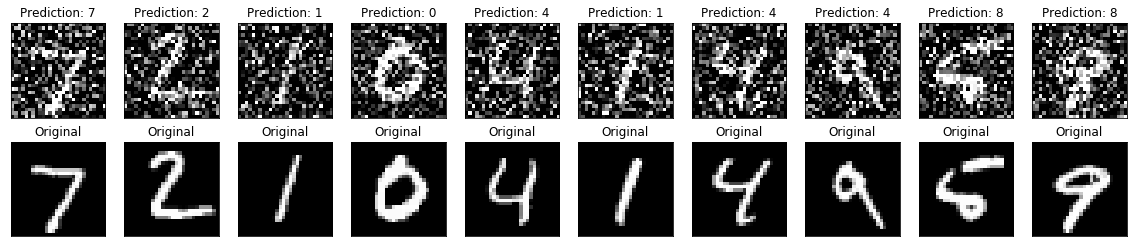

In [37]:
preds = model.predict(X_test_noisy)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Prediction: {}'.format(str(np.argmax(preds[i]))))

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original')
plt.show()